statistical analyses on data exported from `iconference-merge-data.ipynb`

for sentiment, politeness, topic diversity, do comparison between 
- female and male (i.e., gender)，
- patient and doctor (i.e., occupation role)

use t test and regression

then include interaction (product term) between gender and medical role, regress the three linguistic measures above on gender, medical role, and  gender*medical role

note: 
- drop web version score due to the inconsistency (`politeness_web`)
- drop unknown gender (value -1)
- code for 
    - gender: 1 for female and 0 for male
    - role: 1 for patient and 0 for doctor

09-02-2018

---

In [12]:
import pandas as pd
df = pd.read_csv('ohc_data.csv')
df.drop(columns='politeness_web', inplace=True)
df = df[df.gender_dummy!=-1]
df.shape

(20304, 11)

In [13]:
df.columns

Index(['age', 'politeness', 'question_flag', 'role_dummy', 'text', 'url',
       'gender_dummy', 'disease', 'id', 'sentiment_score', 'topic_diversity'],
      dtype='object')

In [28]:
df.dtypes

age                float64
politeness         float64
question_flag        int64
role_dummy           int64
text                object
url                 object
gender_dummy         int64
disease             object
id                  object
sentiment_score    float64
topic_diversity    float64
dtype: object

In [19]:
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [73]:
def get_coef_table(lin_reg):
    ''' lin_reg is a fitted statsmodels regression model
    Return a dataframe containing coefficients, pvalues, and the confidence intervals
    '''
    err_series = lin_reg.params - lin_reg.conf_int()[0]
    coef_df = pd.DataFrame({'coef': lin_reg.params.values[1:],
                            'ci_err': err_series.values[1:],
                            'pvalue': lin_reg.pvalues.round(4).values[1:],
                            'varname': err_series.index.values[1:]
                           })
    return coef_df

In [146]:
import palettable
import seaborn as sns
sns.set_style('white')
from matplotlib import pyplot as plt
%matplotlib inline

---

In [53]:
col_name = ['sentiment_score', 'politeness', 'topic_diversity']

#### statistics w/ t test

first on gender

In [62]:
tval, pval = sp.stats.ttest_ind(df[df.gender_dummy==1][col_name],
                                df[df.gender_dummy==0][col_name],
                               )
pd.DataFrame({'tstats': tval, 'pval': pval}, index=col_name)

,tstats,pval
sentiment_score,-8.221814,2.123739e-16
politeness,-17.088902,5.116461e-65
topic_diversity,-3.324215,8.882459e-04


In [63]:
df[['gender_dummy'] + col_name].groupby('gender_dummy').mean()

,sentiment_score,politeness,topic_diversity
gender_dummy,,,
0,0.155874,0.773950,1.142649
1,0.069417,0.721123,1.123849


then on occpuation

In [64]:
tval, pval = sp.stats.ttest_ind(df[df.role_dummy==1][col_name],
                                df[df.role_dummy==0][col_name],
                               )
pd.DataFrame({'tstats': tval, 'pval': pval}, index=col_name)

,tstats,pval
sentiment_score,-58.129774,0.000000e+00
politeness,-28.321063,4.366943e-173
topic_diversity,-4.370332,1.246734e-05


In [65]:
df[['role_dummy'] + col_name].groupby('role_dummy').mean()

,sentiment_score,politeness,topic_diversity
role_dummy,,,
0,0.381158,0.791572,1.146118
1,-0.180172,0.705939,1.121651


both: mean value across groups

In [66]:
df[['gender_dummy', 'role_dummy']+col_name].groupby(['gender_dummy', 'role_dummy']).mean()

sentiment_score  politeness  topic_diversity
gender_dummy role_dummy                                              
0            0                  0.308300    0.799500         1.156427
             1                 -0.123011    0.727203         1.117439
1            0                  0.551024    0.773087         1.122083
             1                 -0.224647    0.689394         1.124927

---

#### regression

##### test

run for one measure and write a wrapper for all

In [67]:
target_col = 'sentiment_score'

In [71]:
fml_d = {'gender': '{} ~ gender_dummy'.format(target_col),
         'role': '{} ~ role_dummy'.format(target_col),
         'gender+role': '{} ~ gender_dummy + role_dummy'.format(target_col),
         'full': '{} ~ gender_dummy * role_dummy'.format(target_col),
        }
fml_d

{'gender': 'sentiment_score ~ gender_dummy',
 'role': 'sentiment_score ~ role_dummy',
 'gender+role': 'sentiment_score ~ gender_dummy + role_dummy',
 'full': 'sentiment_score ~ gender_dummy * role_dummy'}

In [78]:
result_df = list()
for key, fml in fml_d.items():
    fml_coef_df = get_coef_table(smf.ols(fml, data=df).fit())
    fml_coef_df['model_name'] = key
    result_df.append(fml_coef_df)
result_df = pd.concat(result_df, ignore_index=True)
result_df

,coef,ci_err,pvalue,varname,model_name
0,-0.086457,0.020611,0.0,gender_dummy,gender
1,-0.561330,0.018928,0.0,role_dummy,role
2,0.068497,0.019802,0.0,gender_dummy,gender+role
3,-0.579293,0.019607,0.0,role_dummy,gender+role
4,0.242724,0.027971,0.0,gender_dummy,full
5,-0.431311,0.025778,0.0,role_dummy,full
6,-0.344360,0.039323,0.0,gender_dummy:role_dummy,full


In [82]:
def do_regression(target_col):
    global df
    fml_d = {'gender': '{} ~ gender_dummy'.format(target_col),
             'role': '{} ~ role_dummy'.format(target_col),
             'gender+role': '{} ~ gender_dummy + role_dummy'.format(target_col),
             'full': '{} ~ gender_dummy * role_dummy'.format(target_col),
            }
    result_df = list()
    for key, fml in fml_d.items():
        fml_coef_df = get_coef_table(smf.ols(fml, data=df).fit())
        fml_coef_df['model_name'] = key
        result_df.append(fml_coef_df)
    result_df = pd.concat(result_df, ignore_index=True)
    result_df['target_col'] = target_col
    return result_df

In [83]:
def do_regression_wrapper(target_col_list):
    ''' a list of target columns
    '''
    global df
    result_df = list()
    for target_col in target_col_list:
        result_df.append(do_regression(target_col))
    return pd.concat(result_df, ignore_index=True)

##### apply

In [84]:
col_name

['sentiment_score', 'politeness', 'topic_diversity']

In [85]:
regression_result_df = do_regression_wrapper(col_name)
regression_result_df

,coef,ci_err,pvalue,varname,model_name,target_col
0,-0.086457,0.020611,0.0000,gender_dummy,gender,sentiment_score
1,-0.561330,0.018928,0.0000,role_dummy,role,sentiment_score
2,0.068497,0.019802,0.0000,gender_dummy,gender+role,sentiment_score
3,-0.579293,0.019607,0.0000,role_dummy,gender+role,sentiment_score
4,0.242724,0.027971,0.0000,gender_dummy,full,sentiment_score
5,-0.431311,0.025778,0.0000,role_dummy,full,sentiment_score
6,-0.344360,0.039323,0.0000,gender_dummy:role_dummy,full,sentiment_score
7,-0.052828,0.006059,0.0000,gender_dummy,gender,politeness
8,-0.085633,0.005927,0.0000,role_dummy,role,politeness
9,-0.032179,0.006192,0.0000,gender_dummy,gender+role,politeness


In [185]:
regression_result_df.to_csv('regression-result-iconference.csv', index=False)

---

#### visualization

In [132]:
bar_df = df[['gender_dummy', 'role_dummy']+col_name].groupby(['gender_dummy', 'role_dummy']).mean()
bar_df

sentiment_score  politeness  topic_diversity
gender_dummy role_dummy                                              
0            0                  0.308300    0.799500         1.156427
             1                 -0.123011    0.727203         1.117439
1            0                  0.551024    0.773087         1.122083
             1                 -0.224647    0.689394         1.124927

In [136]:
bar_df = bar_df.swaplevel()
bar_df = bar_df.reindex(axis=0, level=0, labels=[0,1])
#bar_df = bar_df.reindex(axis=0, level=1, labels=[0,1,0,1])
bar_df

sentiment_score  politeness  topic_diversity
role_dummy gender_dummy                                              
0          0                    0.308300    0.799500         1.156427
           1                    0.551024    0.773087         1.122083
1          0                   -0.123011    0.727203         1.117439
           1                   -0.224647    0.689394         1.124927

In [169]:
val_mat = bar_df.values.flatten()
val_mat

array([ 0.30830024,  0.79950013,  1.15642696,  0.55102445,  0.77308733,
        1.12208315, -0.12301122,  0.72720319,  1.11743948, -0.22464748,
        0.68939354,  1.12492699])

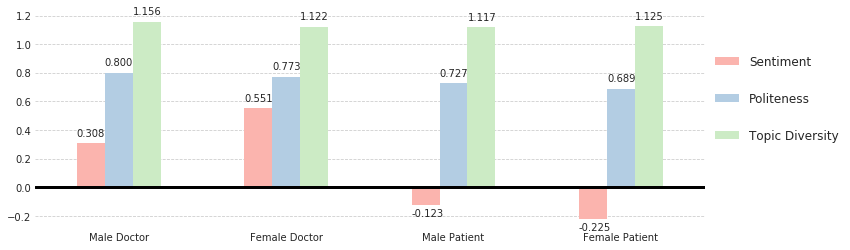

In [182]:
fig, ax = plt.subplots(figsize=(12, 4))
bar_df.plot(kind='bar', legend=False, ax=ax,
            colormap=palettable.colorbrewer.qualitative.Pastel1_3.mpl_colormap)
ax.legend(loc=6, bbox_to_anchor=[1, 0.6], 
          labels=['Sentiment', 'Politeness', 'Topic Diversity'],
          labelspacing=2, fontsize=12)
ax.axhline(y=0, c='k', lw=3)
ax.yaxis.grid(True, ls='--')
ax.set_frame_on(False)
ax.set_xticklabels(['Male Doctor', 'Female Doctor', 'Male Patient', 'Female Patient'], 
                   rotation=0)
ax.set_xlabel('')
    
for i, patch in enumerate(ax.patches):
    x, _ = patch.xy
    y = patch.get_height()
    if y > 0:
        ax.text(x, y+0.05, '{:.3f}'.format(y))
    else:
        ax.text(x, y-0.08, '{:.3f}'.format(y))